# Convergence of numerical solutions to weak solutions of conservation laws

This worksheet follows the discussion in [LeVeque, 1992] Chapter 12.  Solutions of hyperbolic PDEs develop discontinuities, so we have to consider weak solutions that satisfy an integral conservation law.
We'll consider the inviscid Burgers' equation:

$$q_t + \left(\frac{1}{2} q^2\right)_x = 0$$

discretized by two simple finite difference methods.  The first is simply the upwind method applied to Burgers' equation:

$$Q^{n+1}_j = Q^n_j - \frac{\Delta t}{2\Delta x} \left((Q^n_j)^2 - (Q^n_{j-1})^2\right)$$

The second discretization is obtained by writing Burgers' equation in quasilinear form:

$$u_t + uu_x = 0$$

and using an upwind difference:

$$Q^{n+1}_j = Q^n_j - \frac{\Delta t}{\Delta x} Q^n_j\left(Q^n_j - Q^n_{j-1}\right)$$

The first method is conservative, since the fluxes will cancel out if we sum over the whole grid.  The second method is not conservative.  Let's implement them and see what happens.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time, sys
import matplotlib
from matplotlib import animation
from JSAnimation import IPython_display

In [15]:
def take_step(q,dt,dx,method):
    if method == 'conservative':
        q[1:-1] = q[1:-1] - 0.5*dt/dx * ( q[1:-1]**2 - q[:-2]**2 )
    elif method == 'non-conservative':
        q[1:-1] = q[1:-1] - dt/dx * q[1:-1] * (q[1:-1] - q_nc[0:-2]) 
    return q


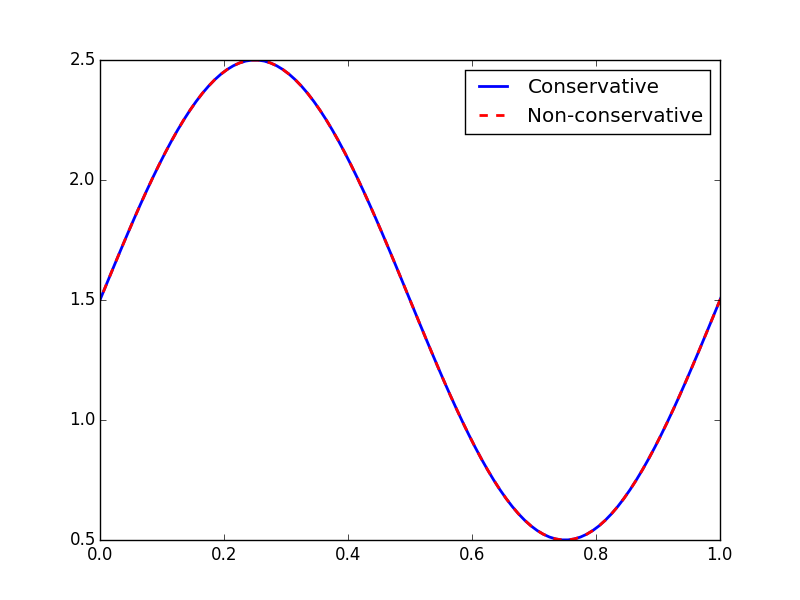
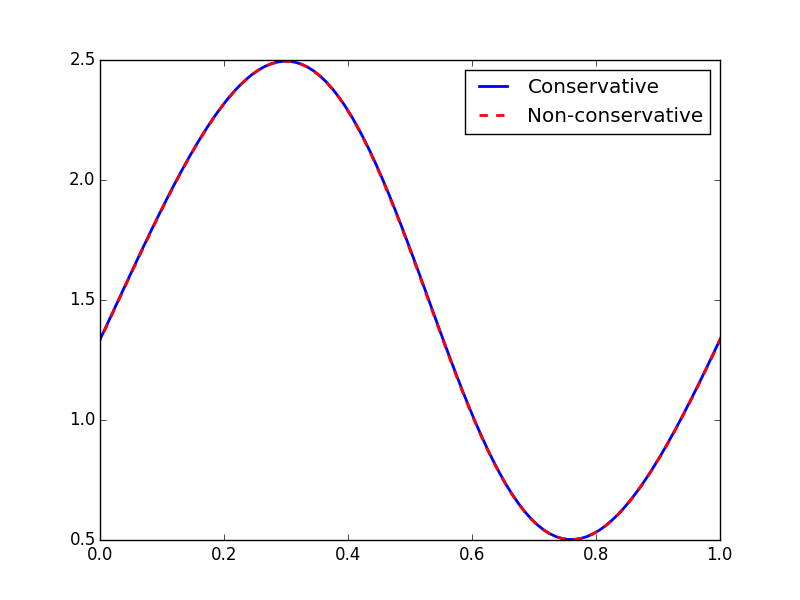
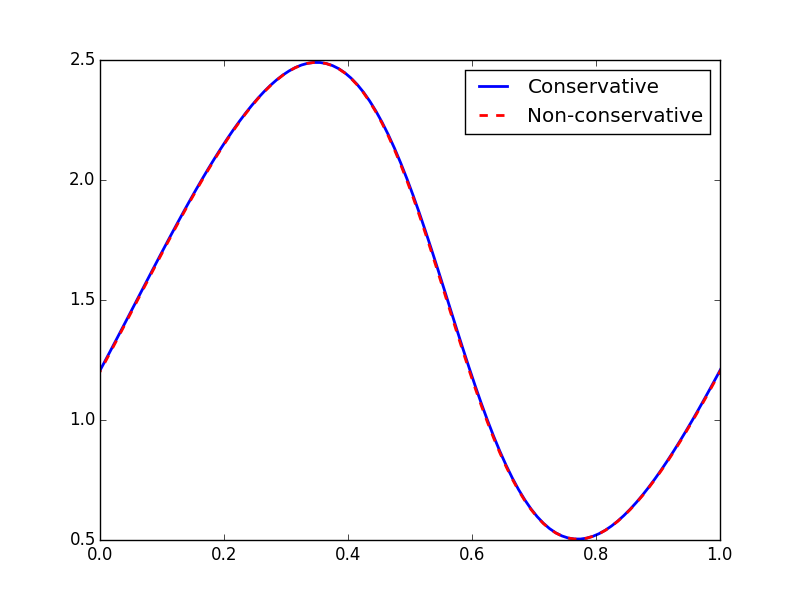
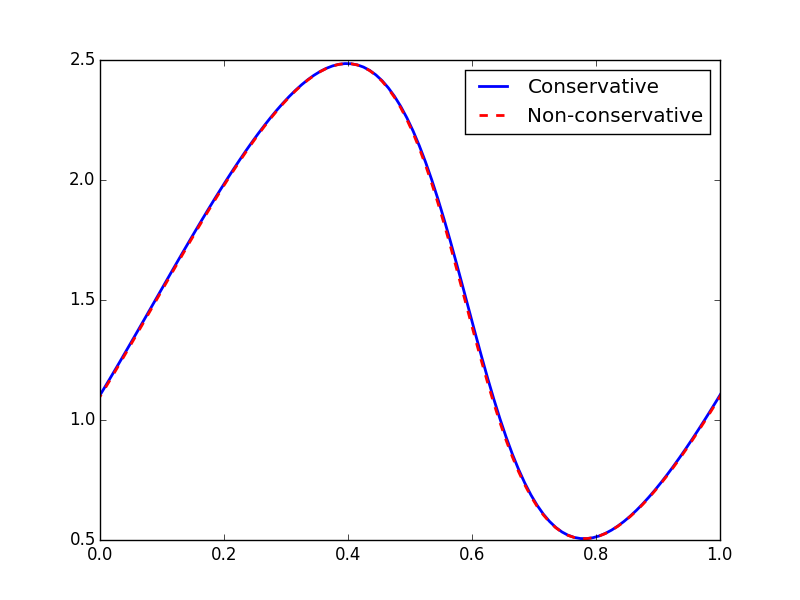
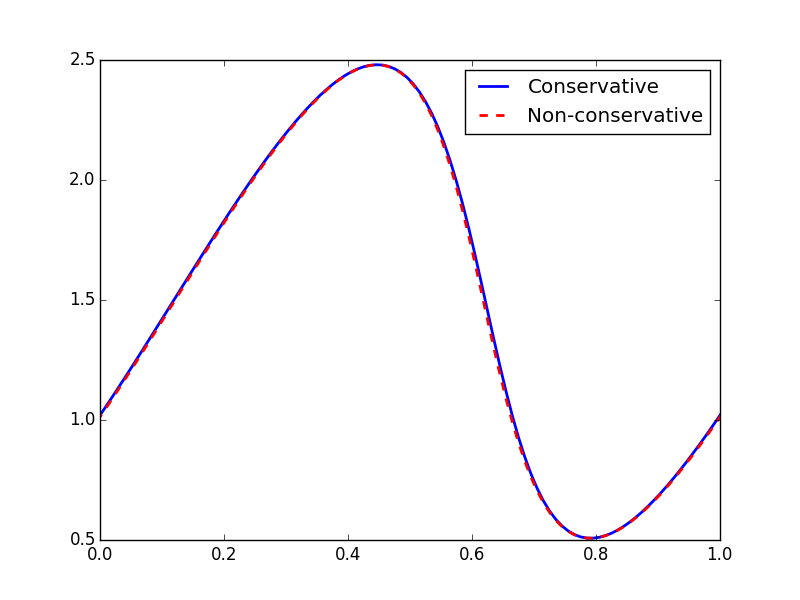
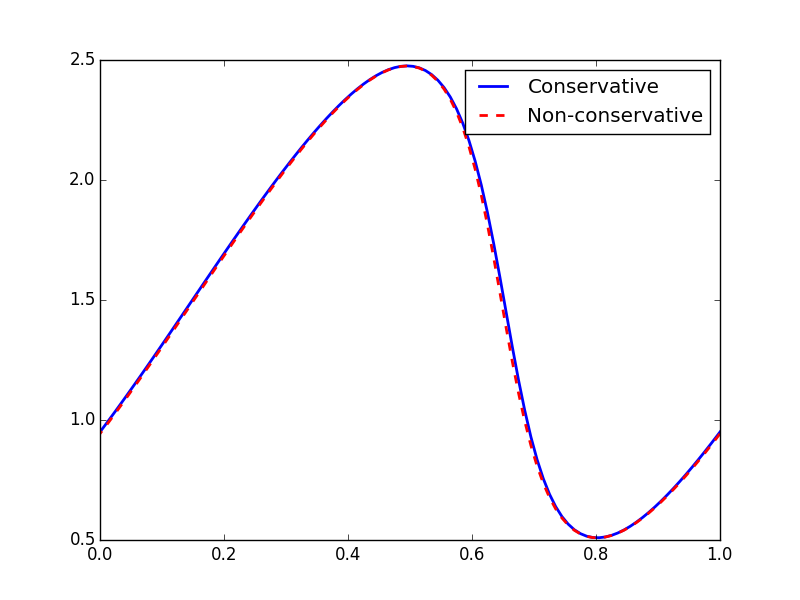
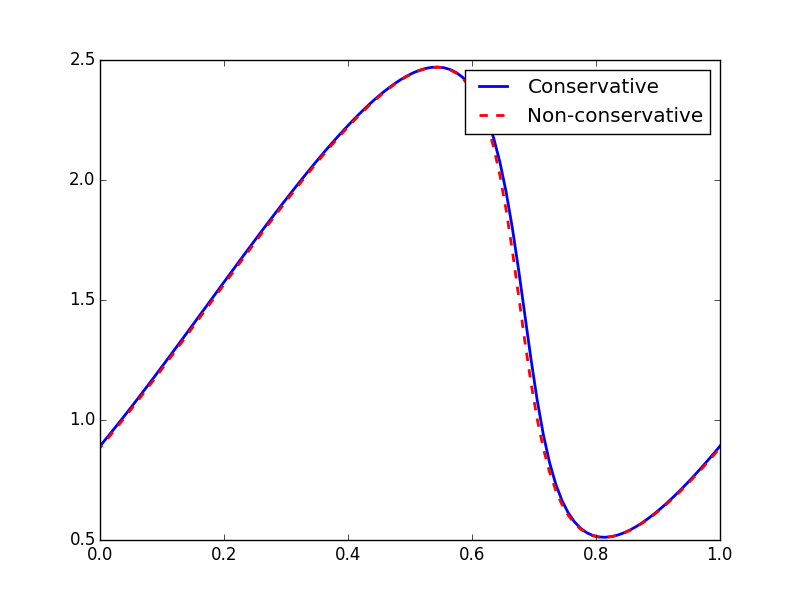
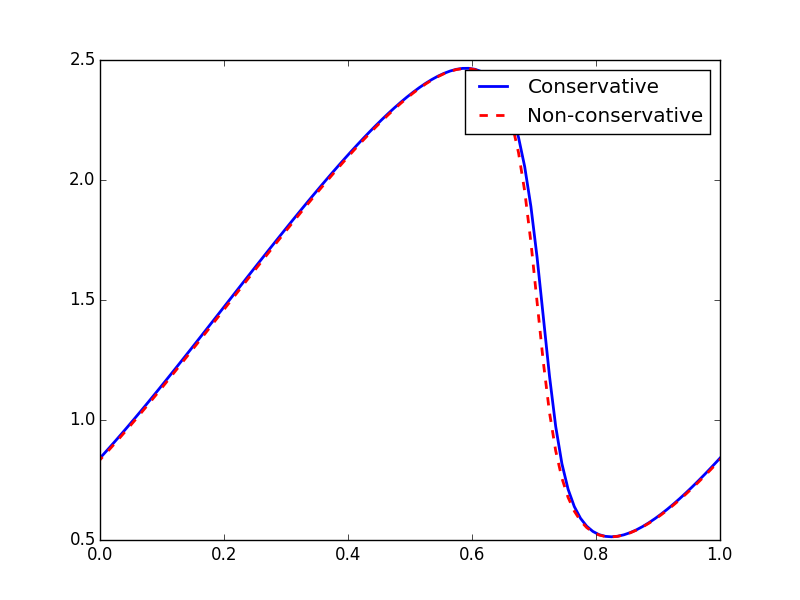
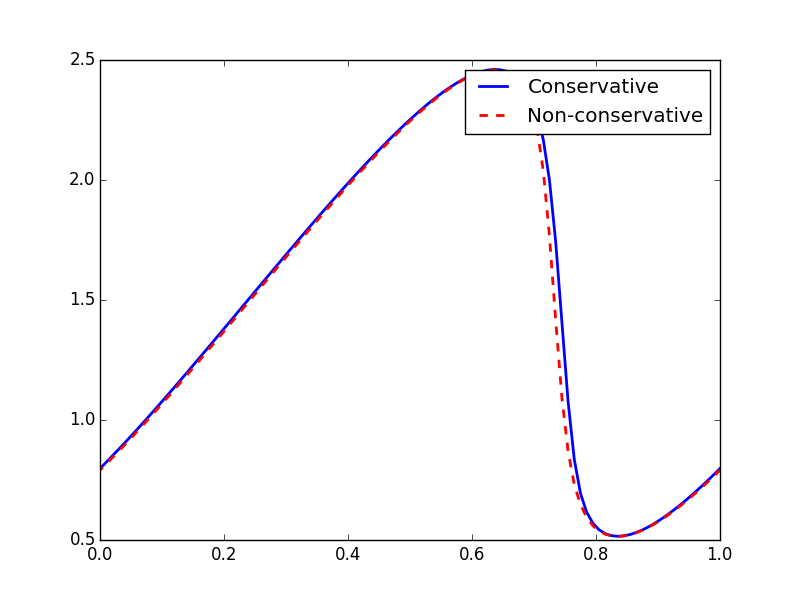
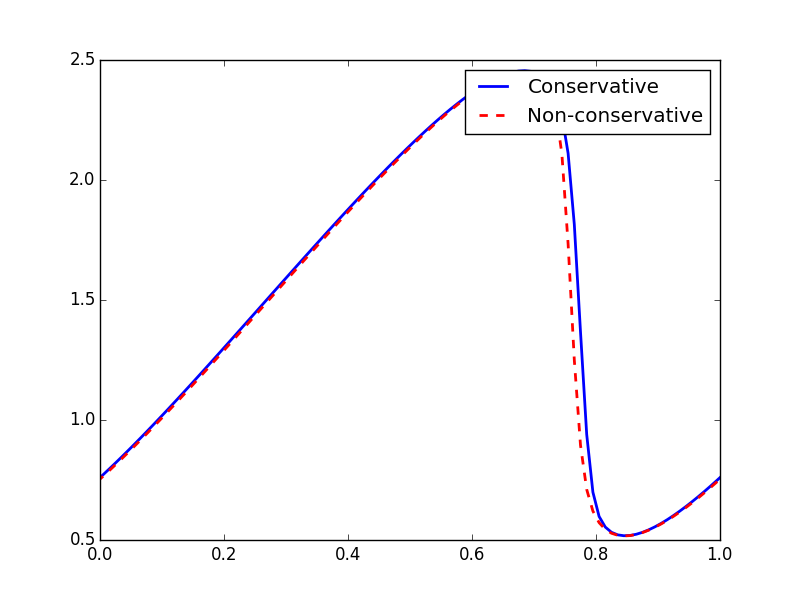
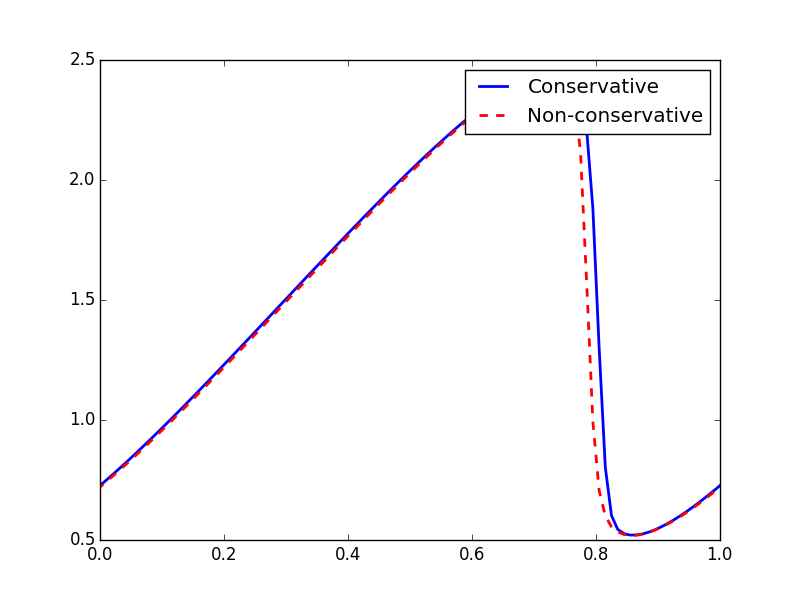
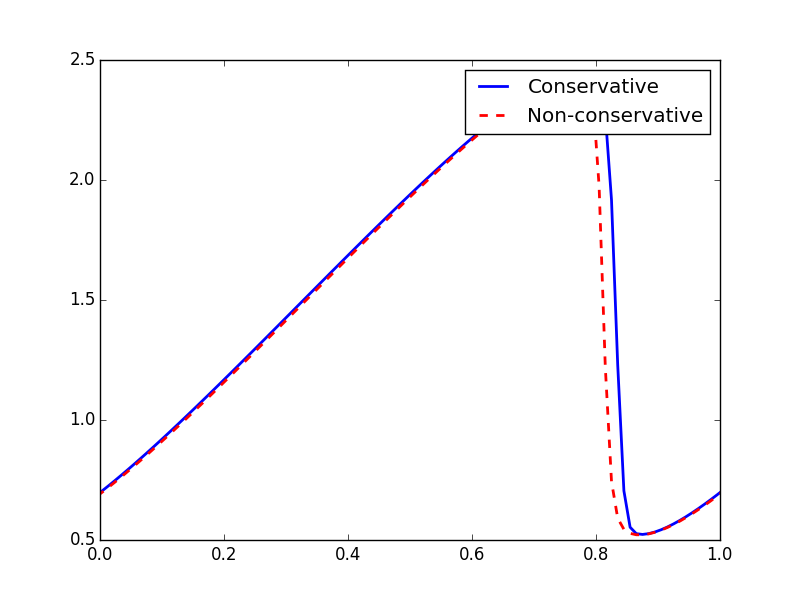
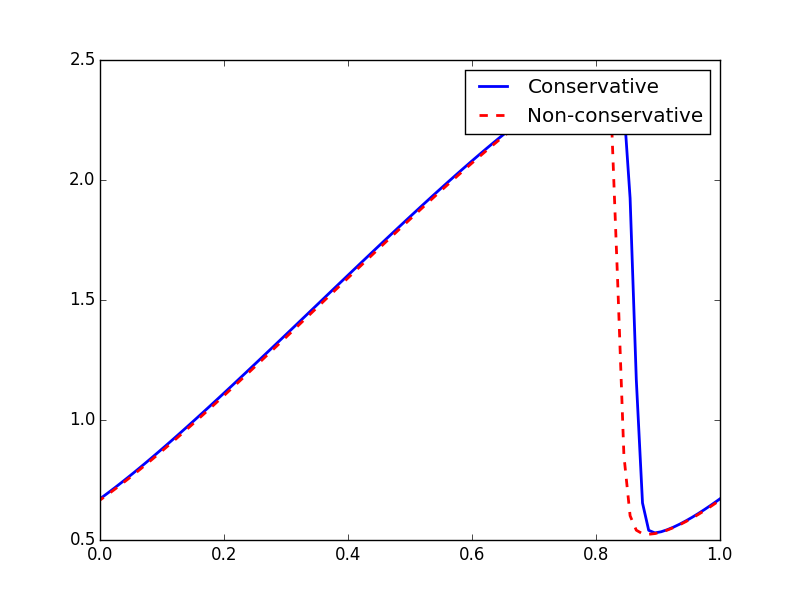
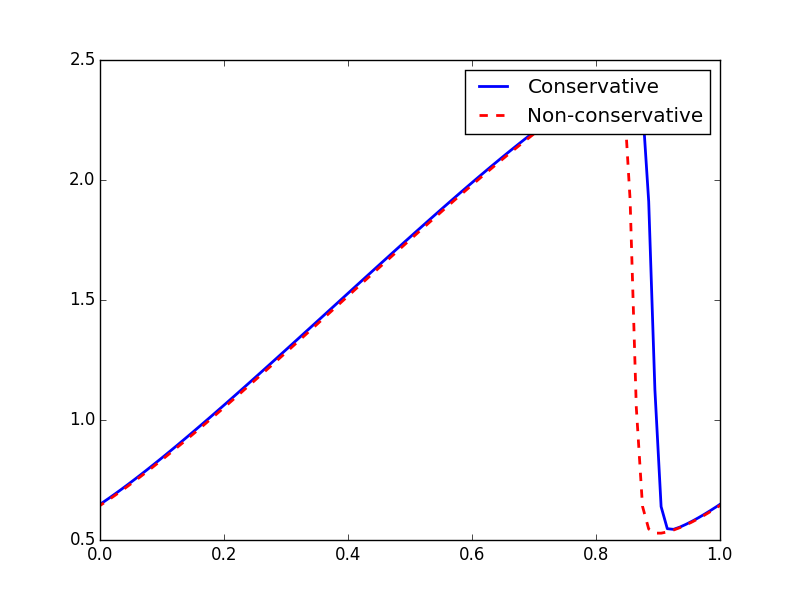
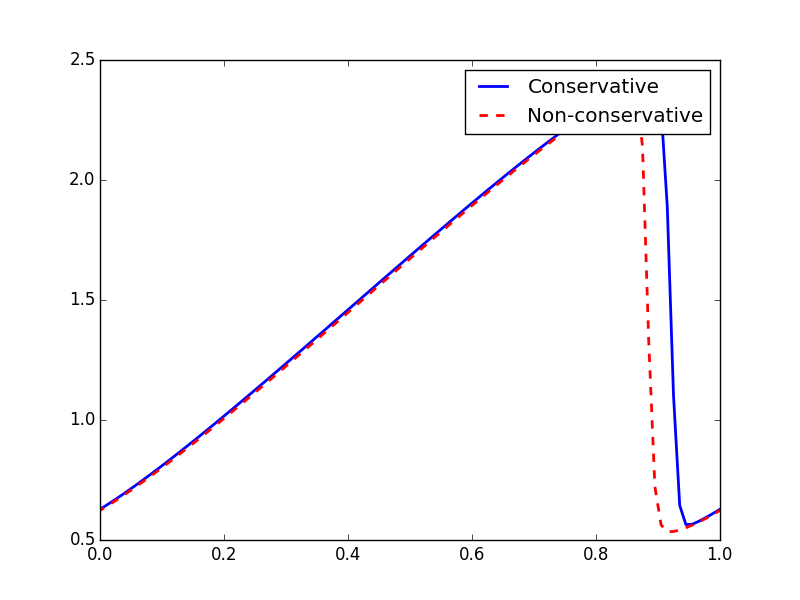
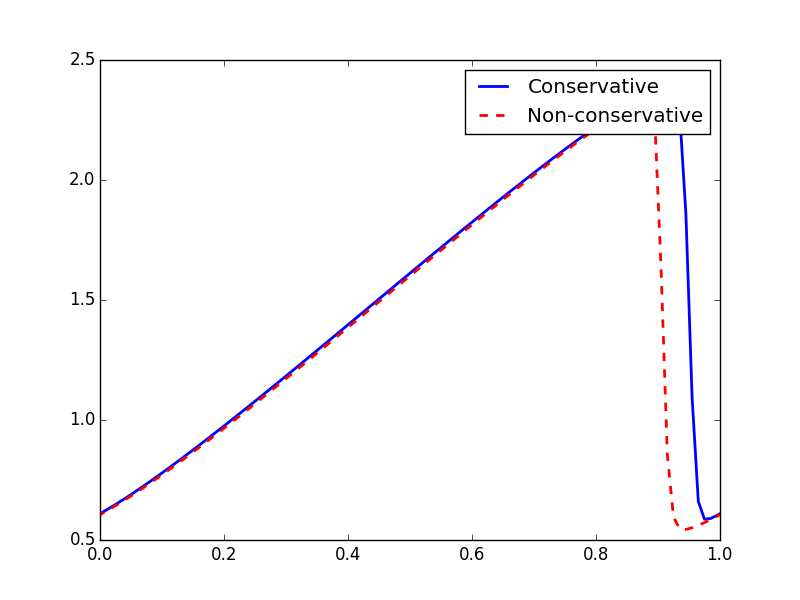
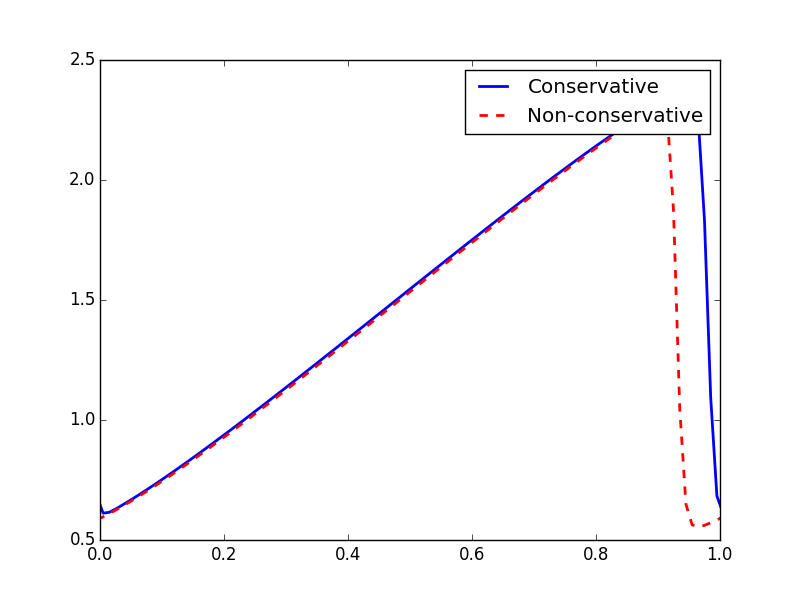
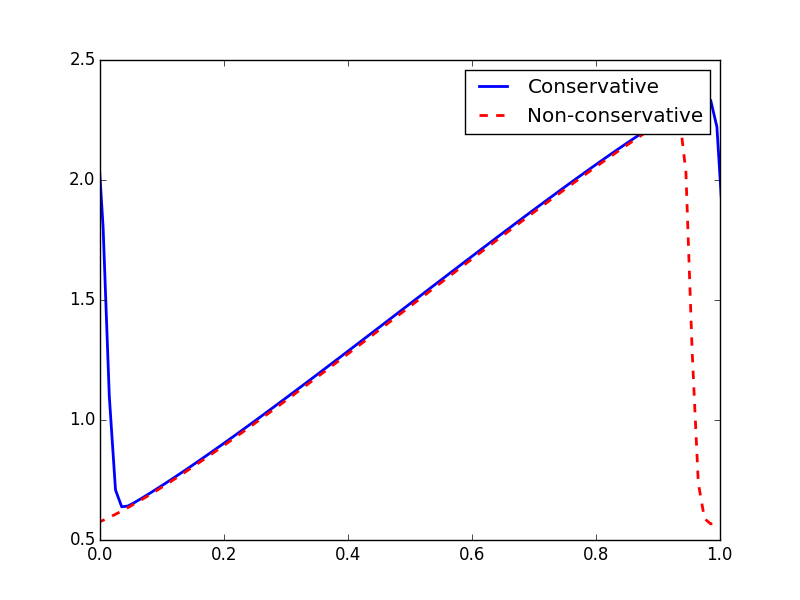
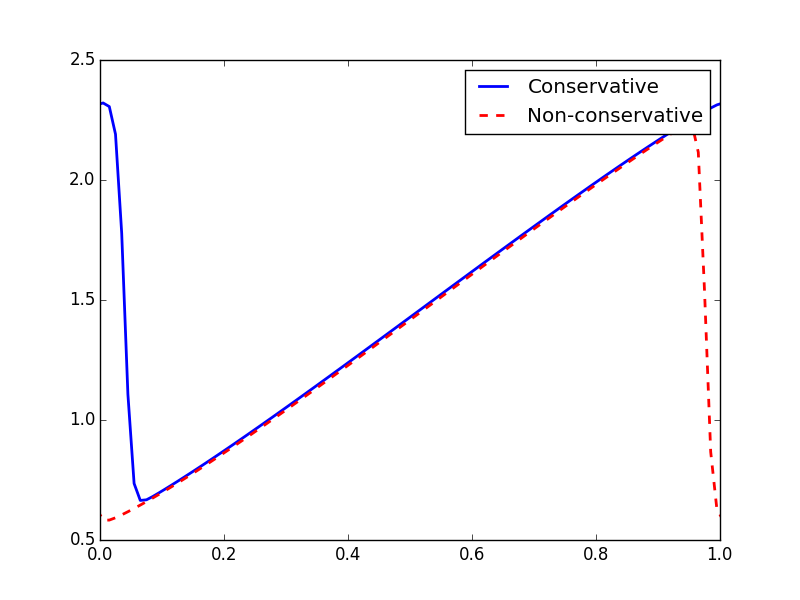
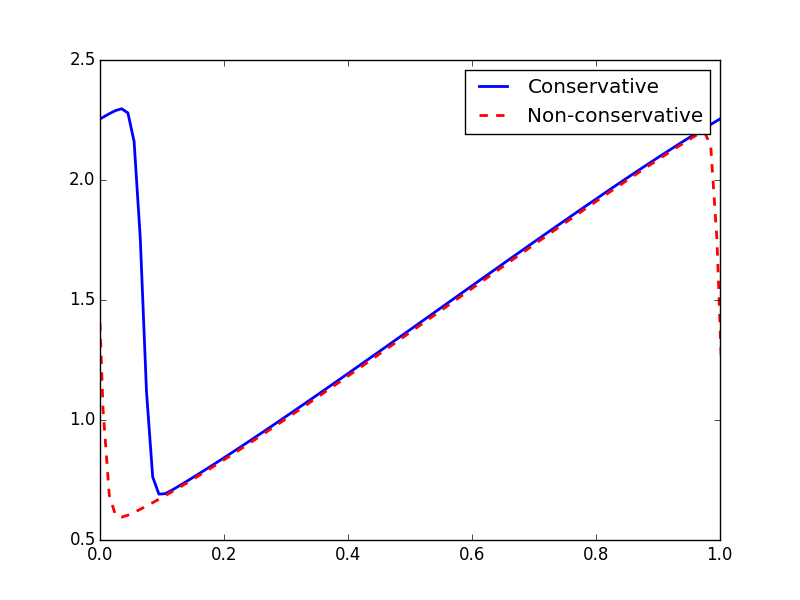
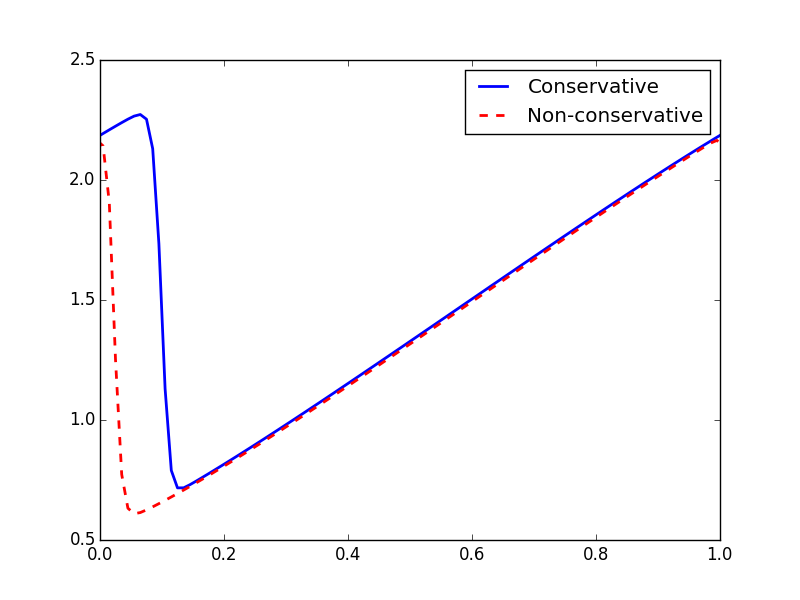
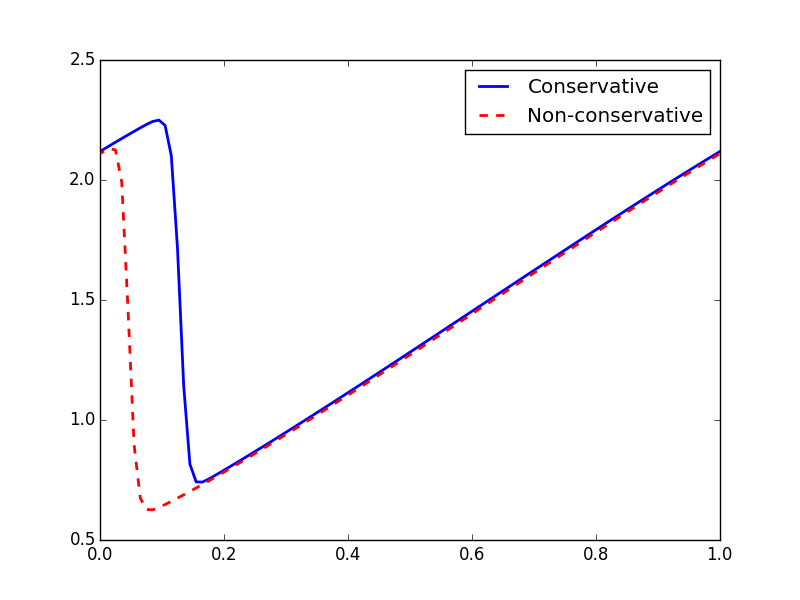
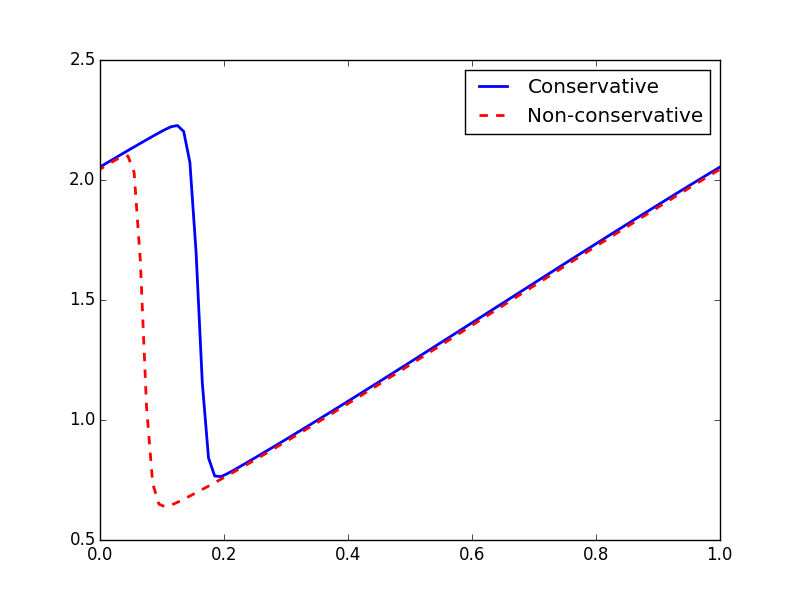
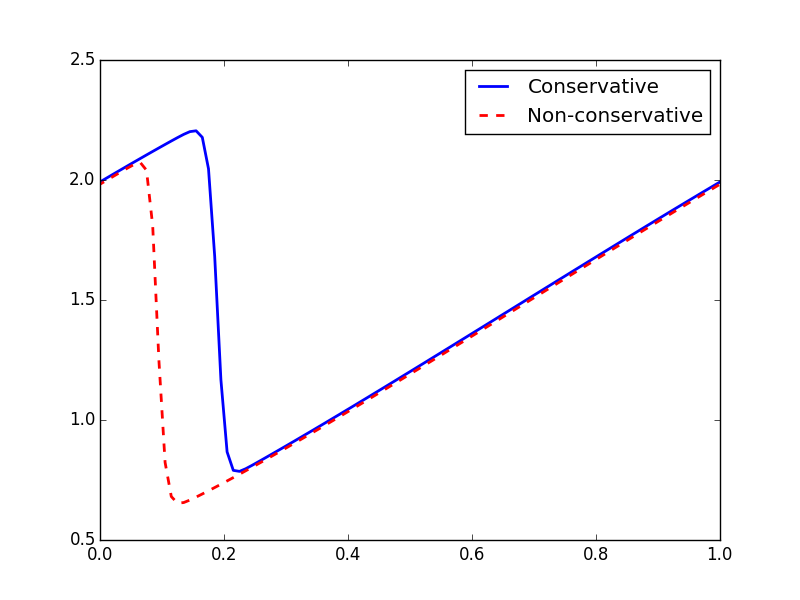
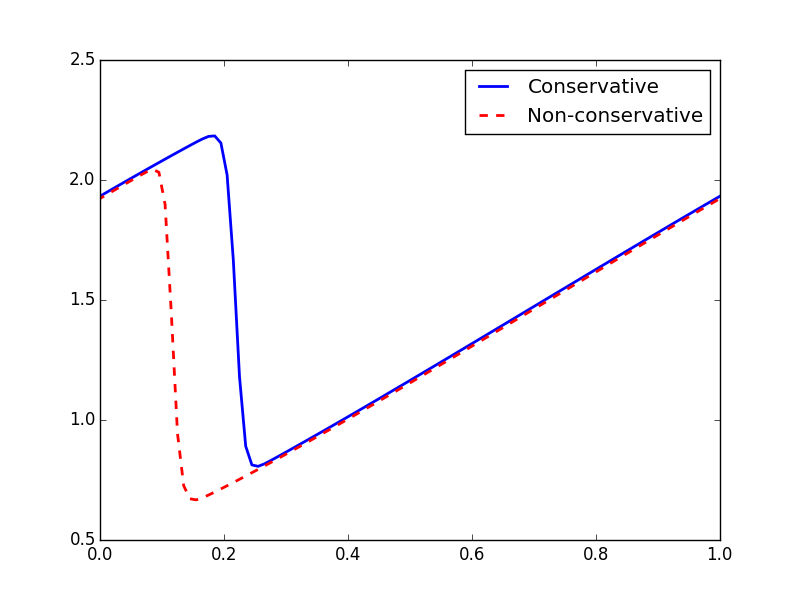
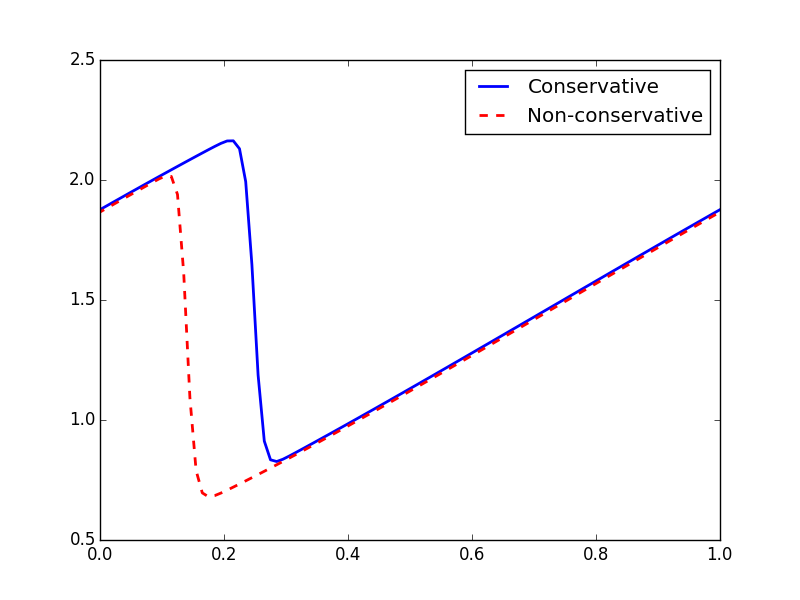

In [17]:
cflnum=0.5;
N=100;  # Number of grid points
plot_interval = N/10  # Draw a plot every n time steps

dx=1./N;
nghost = 1; N2=N+2*nghost;  # Ghost cells used for implementing boundary conditions
x=np.linspace(-(nghost-0.5)*dx,1.+(nghost-0.5)*dx,N2)
t=0.; T=0.5; # Initial and final time

q0 = np.sin(2*np.pi*x) + 1.5   # Smooth initial data
q_c = q0.copy();
q_nc= q0.copy();

dt=cflnum*dx/np.max(q0);

# Set up plotting
fig = plt.figure()
axes = fig.add_subplot(111)
line1, = axes.plot(x,q0,lw=2)
line2, = axes.plot(x,q0,'r--',lw=2)
axes.set_xlim(0.,1.)
axes.legend(['Conservative','Non-conservative'])

frames1 = [q0.copy()]
frames2 = [q0.copy()]

i = 0
while t<T:
    if dt>T-t: dt=T-t
        
    q_c  = take_step(q_c ,dt,dx,'conservative')
    q_nc = take_step(q_nc,dt,dx,'non-conservative')

    for q in [q_c, q_nc]:  # Periodic boundary conditions
        q[0:nghost]  = q[-2*nghost:-nghost] 
        q[-nghost:]  = q[nghost:2*nghost]
        
    t = t + dt
    i = i + 1
    if (i % plot_interval) == 0:
        frames1.append(q_c.copy())
        frames2.append(q_nc.copy())
        
def plot_frame(i):
    line1.set_data(x,frames1[i])
    line2.set_data(x,frames2[i])

matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(frames1), interval=200)

We see that the two solutions are in very good agreement before the shock forms, but afterward the shocks move at different speeds.  Try refining the grid.  Do the solutions converge to the same thing?

This effect is even more obvious if we solve a Riemann problem.  We take $q_l = 1, q_r = 1/2$, so the correct shock speed is $(q_l+q_r)/2 = 3/4$.


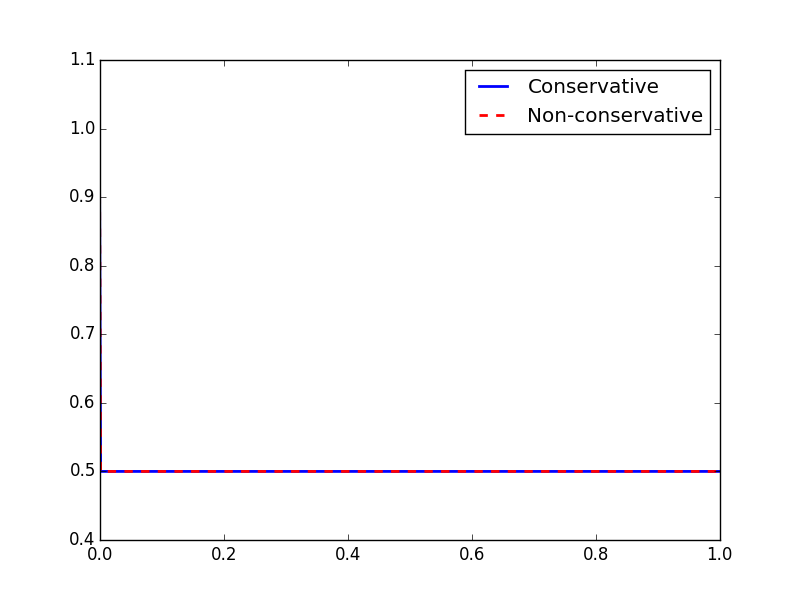
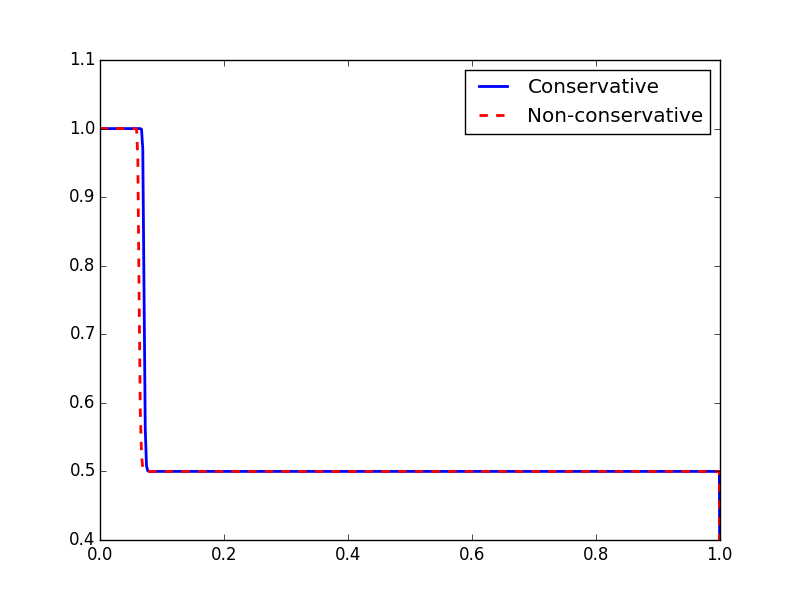
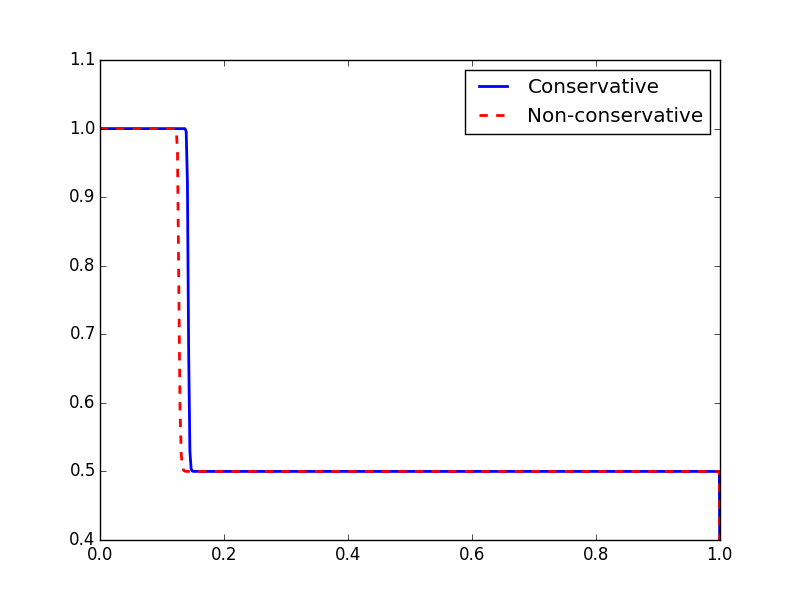
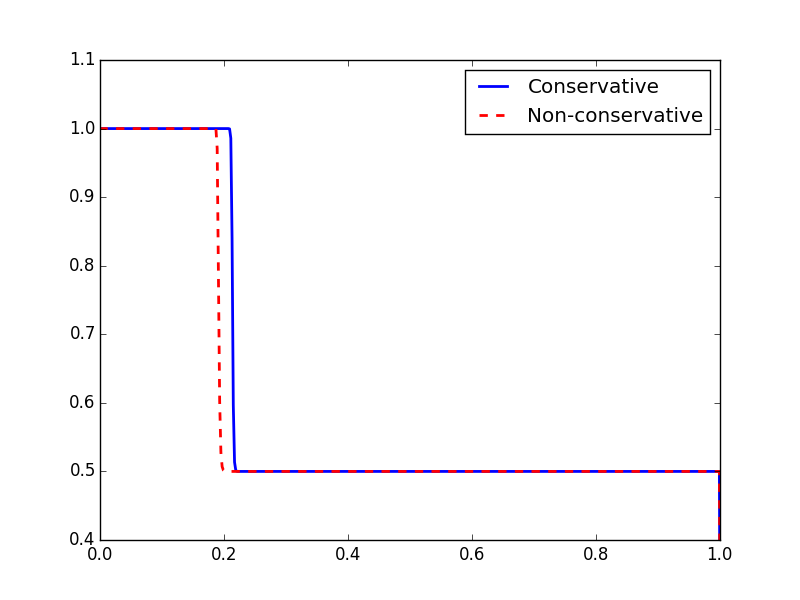
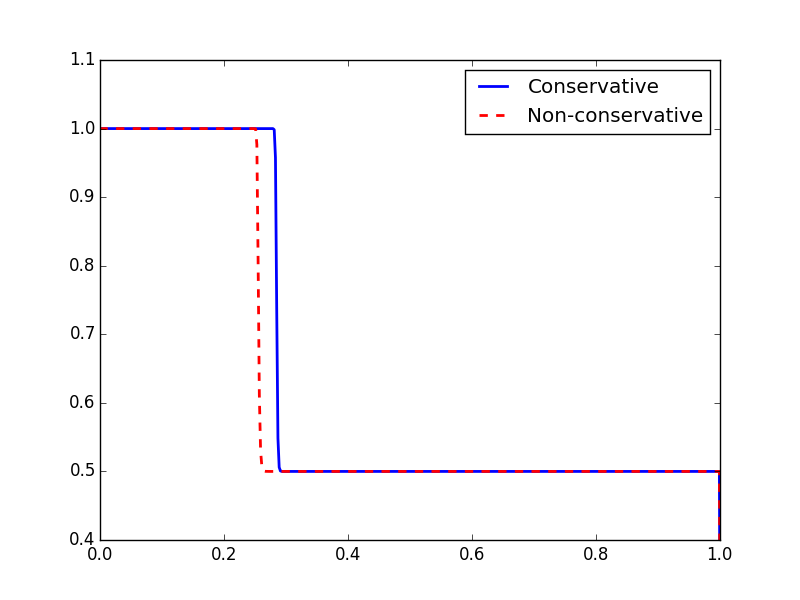
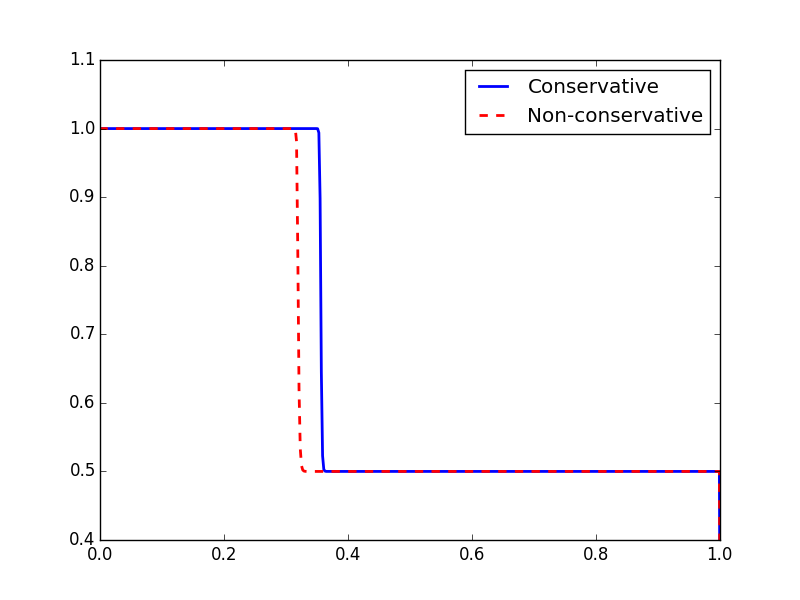
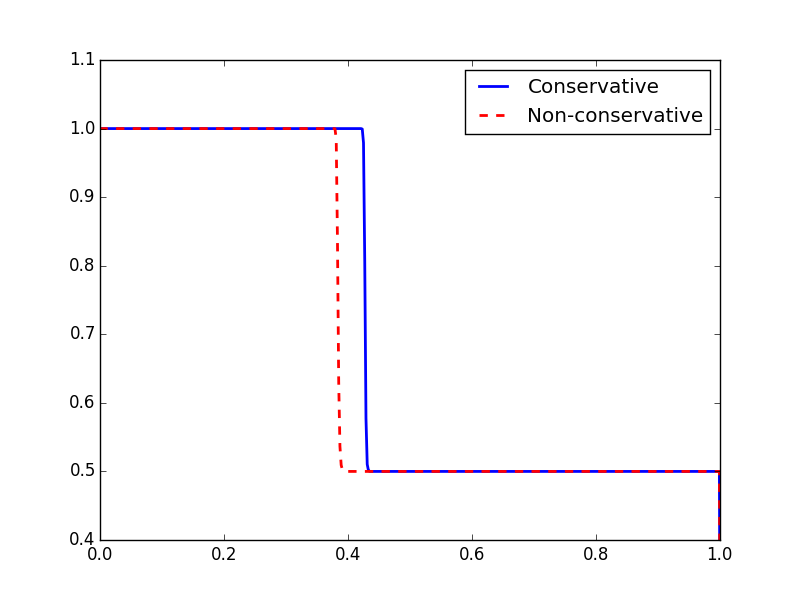
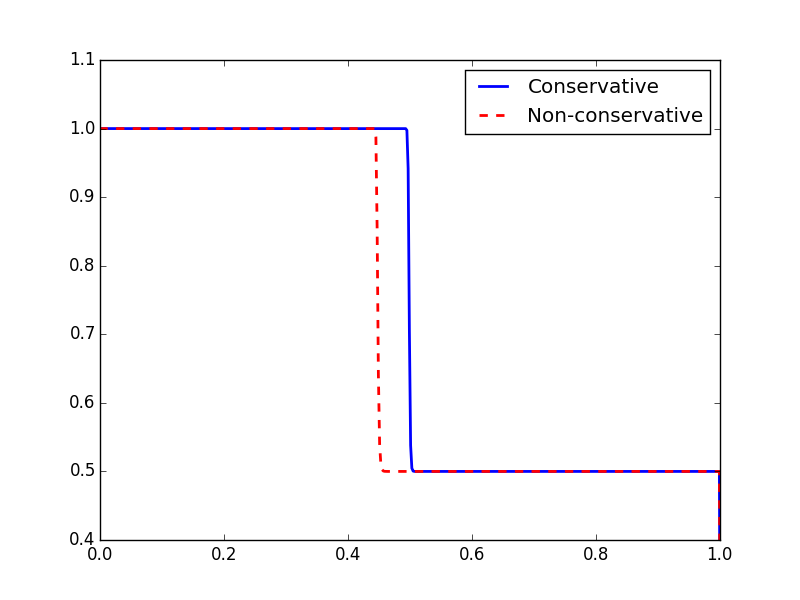
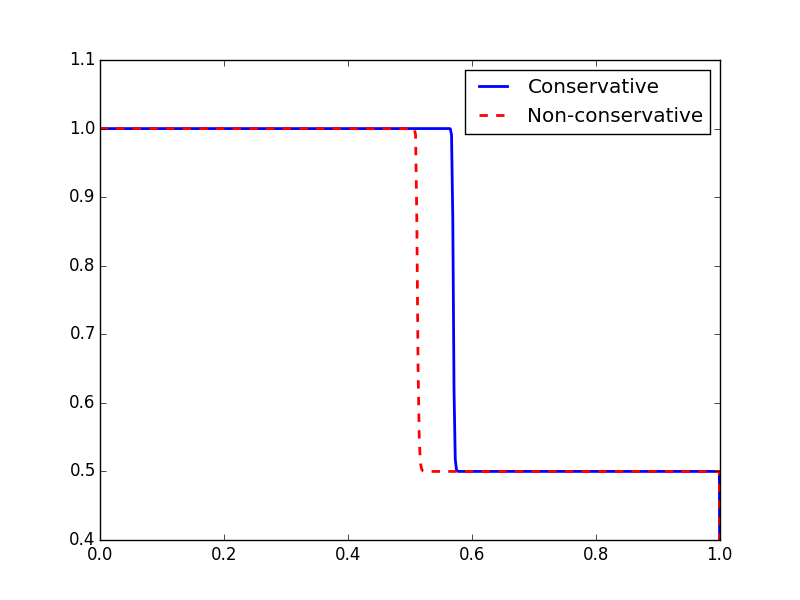
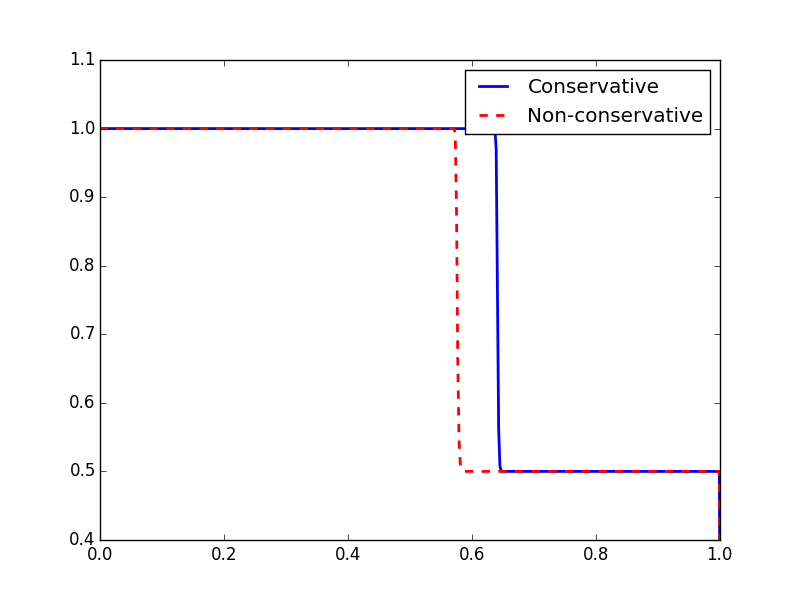
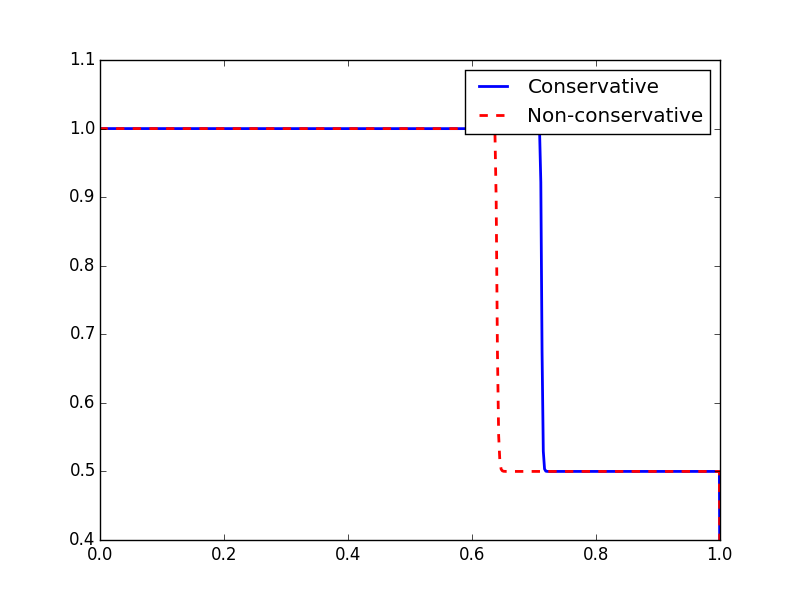

In [13]:
cflnum=0.95;
N=500;  # Number of grid points
plot_interval = N/10  # Draw a plot every n time steps

dx=1./N;
nghost = 1; N2=N+2*nghost;  # Ghost cells used for implementing boundary conditions
x=np.linspace(-(nghost-0.5)*dx,1.+(nghost-0.5)*dx,N2)
t=0.; T=1.; # Initial and final time

q0 = 1.*(x<0.) + 0.5*(x>=0.)
q_c = q0.copy();
q_nc= q0.copy();

dt=cflnum*dx/np.max(q0);

# Set up plotting
fig = plt.figure()
axes = fig.add_subplot(111)
line1, = axes.plot(x,q0,lw=2)
line2, = axes.plot(x,q0,'r--',lw=2)
axes.set_xlim(0.,1.)
axes.set_ylim(0.4,1.1)
axes.legend(['Conservative','Non-conservative'])

frames1 = [q0.copy()]
frames2 = [q0.copy()]

i = 0
while t<T:
    if dt>T-t: dt=T-t
        
    q_c  = take_step(q_c ,dt,dx,'conservative')
    q_nc = take_step(q_nc,dt,dx,'non-conservative')

    for q in [q_c, q_nc]:  # Dirichlet boundary conditions
        q[0:nghost]  = 1.
        q[-nghost:]  = 0.
        
    t = t + dt
    i = i + 1
    if (i % plot_interval) == 0:
        frames1.append(q_c.copy())
        frames2.append(q_nc.copy())
        
def plot_frame(i):
    line1.set_data(x,frames1[i])
    line2.set_data(x,frames2[i])
    
matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(frames1), interval=200)

We see that the conservative method propagates the shock at the correct speed of 3/4, but the non-conservative method shock speed is about 2/3.

  Different conservation laws may be equivalent for smooth solutions but may have different weak solutions.  Numerical methods must satisfy the appropriate conservation law discretely; otherwise, they may converge to a weak solution of a different conservation law, which is just what we've observed here.

# Conservation and shock speed
What does conservation have to do with getting the correct weak solution?  Well, as we've seen above, different weak solutions involve different shock speeds.  Recall the integral conservation law:

$$\int_{x_1}^{x_2} q(x,t_2) dx = \int_{x_1}^{x_2} q(x,t_1) dx - \int_{t_1}^{t_2} \left( f(q(x_1,t)) - f(q(x_2,t)) \right)$$

Taking $x_1=0, x_2=1, f(q) = q^2/2$, we have (with the Riemann data of the problem above)

$$\int_{0}^{1} q(x,t_2) dx - \int_{0}^{1} q(x,t_1) dx = \frac{1}{2}\int_{t_1}^{t_2} \left( q(0,t)^2 - q(1,t)^2 \right) = (t_2-t_1)(1^2 - 1/2^2)/2 = 3/8.$$

Since the value of $q$ jumps from 1/2 to 1 across the shock, the actual increase in $\int q dx$ for a solution is just $(t_2-t_1)s/2$, where $s$ is the shock speed.  Thus, the integral conservation law can only be satisfied if the shock speed is (in this case) $s=3/4$.